Apologize for the messy notebook - still trying to mess around with this stuff.

## Prelim Prep/Imports

In [228]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [229]:
df = pd.read_excel("SupplyChain_TimeSeriesData.xlsx")

In [230]:
# Using the Pandas bdate_range function, we calculate number of days taken to complete order (excluding weekends)
df['scheduled_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Schedule Start Date'], row['Schedule Finish Date']).shape[0] \
                                            if not pd.isna(row['Schedule Start Date']) and not pd.isna(row['Schedule Finish Date']) else np.nan, axis=1 )
df['actual_duration_nowkend'] = df.apply(lambda row: pd.bdate_range( row['Confirmation Start Date'], row['Usage Decision Date']).shape[0] \
                                         if not pd.isna(row['Confirmation Start Date']) and not pd.isna(row['Usage Decision Date']) else np.nan, axis=1 )

# Drop null values
df = df.dropna(subset=['Confirmation Start Date', 'Usage Decision Date'])

# Drop dates before 2016
orders = df[df['Schedule Finish Date'] < pd.Timestamp(2017,1,1)]['Order'].unique()
df = df[~df['Order'].isin(orders)]

df.head()

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
537,100657,100000798,B23943,134,1,345.0,ML,343.00,2018-12-03,2018-12-04,2016-11-10,2016-11-14,2016-11-17,2016-11-23,10,2,10
684,100601,100000450,B22732,131,1,1.4,L,1.39,2018-12-03,2018-12-04,2016-11-28,2016-11-14,2016-12-01,2016-12-01,4,2,4
687,100599,100000410,B23304,134,1,3.0,L,2.95,2017-10-23,2017-10-31,2016-11-18,2016-11-21,2016-11-22,2016-12-01,10,7,10
698,101969,100002022,B24354,138,12,200.0,ML,213.20,2017-01-04,2017-01-10,2016-11-29,2016-11-29,2016-11-30,2016-12-01,3,5,3
773,101593,100000200,B24063,166,6,100000.0,µL,100000.00,2016-11-30,2017-01-10,2016-11-14,2016-11-14,2016-12-02,2016-12-05,16,30,16


In [231]:
#Change the units to ML
df.loc[df["Unit"] == "µL", "Total order quantity"] = df["Total order quantity"]/1000
df.loc[df["Unit"] == "µL", "Unit"] = "ML"

df.loc[df["Unit"] == "L", "Total order quantity"] = df["Total order quantity"] * 1000
df.loc[df["Unit"] == "L", "Unit"] = "ML"

display(df.shape)
display(df.head())

(32165, 17)

,Order,Material,Batch,Group,MaterialCategory,Total order quantity,Unit,Quantity of goods received,Schedule Start Date,Schedule Finish Date,Confirmation Start Date,First Goods Movement Date,Goods Receipt Date,Usage Decision Date,dur,scheduled_duration_nowkend,actual_duration_nowkend
537,100657,100000798,B23943,134,1,345.0,ML,343.00,2018-12-03,2018-12-04,2016-11-10,2016-11-14,2016-11-17,2016-11-23,10,2,10
684,100601,100000450,B22732,131,1,1400.0,ML,1.39,2018-12-03,2018-12-04,2016-11-28,2016-11-14,2016-12-01,2016-12-01,4,2,4
687,100599,100000410,B23304,134,1,3000.0,ML,2.95,2017-10-23,2017-10-31,2016-11-18,2016-11-21,2016-11-22,2016-12-01,10,7,10
698,101969,100002022,B24354,138,12,200.0,ML,213.20,2017-01-04,2017-01-10,2016-11-29,2016-11-29,2016-11-30,2016-12-01,3,5,3
773,101593,100000200,B24063,166,6,100.0,ML,100000.00,2016-11-30,2017-01-10,2016-11-14,2016-11-14,2016-12-02,2016-12-05,16,30,16


## Grouping
Groups based on the assumption that the hierarchy is category -> group -> material from least precise to most precise. Starts by determining all possible groupings of material that have enough data to make a forecast, then moves to group, and finally to category. This information is stored in dictionaries mat_trend, group_trend, cat_trend.

In [346]:
import copy
types = ['Material', 'Group', 'MaterialCategory']
dics = {'mat_trend' : {}, 'group_trend' : {}, 'cat_trend' : {}}
thresholds = [75,75,50]


for (typ, dic, thresh) in zip(types, dics, thresholds):
    # Group 
    gr = df.groupby(typ)
    groups = dict(list(gr))
    # Checks if group has enough data
    for x in groups:
        single = groups[x]
        if len(single) > thresh:
            dics[dic][x] = single

# Transfer back over for ease later            
mat_trend = dics['mat_trend']
group_trend = dics['group_trend']
cat_trend = dics['cat_trend']

# Lists of keys
mats = list(mat_trend.keys())
groups = list(group_trend.keys())
cats = list(cat_trend.keys())

# Note to self: 48, 42, 11
print("Material groups that have enough data: %d" % len(mat_trend))
print("Group groups that have enough data: %d" % len(group_trend))
print("Category groups that have enough data: %d" % len(cat_trend))

Material groups that have enough data: 48
Group groups that have enough data: 42
Category groups that have enough data: 11


## Get Rid of Outliers

In [338]:
def remove_outliers(group, method):
    if method == 'zscore':
        group['zscore'] = np.abs(stats.zscore(group['actual_duration_nowkend']))
        group = group.loc[group['zscore'] < 3]
    elif method == 'iqr':
        lower = np.quantile(group['actual_duration_nowkend'], 0.25) 
        upper = np.quantile(group['actual_duration_nowkend'], 0.75) 
        group = group.loc[(group['actual_duration_nowkend'] >= lower) & (group['actual_duration_nowkend'] <= upper)]
    group = group.sort_values(by='Usage Decision Date')
    return group

In [390]:
lists = [mats, groups, cats]
dics = [mat_trend, group_trend, cat_trend]
types = ['Material', 'Group', 'MaterialCategory']

# new dictionaries to copy over data without outliers
mat_trend_trim = {}
group_trend_trim = {}
cat_trend_trim = {}
new_dics = [mat_trend_trim, group_trend_trim, cat_trend_trim]


# Track amount of datapoints deleted
deltas = []
# method for outlier detection - choose zscore or iqr
method = 'zscore'
for (typ, lis, olddic, newdic) in zip(types, lists, dics, new_dics):
    delta = []
    for x in lis:
        group = olddic[x]
        start = len(group)
        # Get rid of outliers
        group = remove_outliers(group, method)
        newdic[x] = group
        # calculate datapoints lost
        end = len(group)
        delta.append([x, start, end, start-end, (100*(start-end)/start)])
    #append to overall list    
    deltas.append(pd.DataFrame(delta, columns=[typ, 'Start', 'End', 'Delta', 'Percentlost']))
    

In [391]:
# Shows data loss with outlier method 
# 0 = Materials, 1 = Group, 2 = MaterialCategory
print('Materials outlier mean data percent lost: %0.2f' % deltas[0]['Percentlost'].mean())
print('Groups outlier mean data percent lost: %0.2f' % deltas[1]['Percentlost'].mean())
print('MaterialCategory outlier mean data percent lost: %0.2f' % deltas[2]['Percentlost'].mean())

#Results: 

# For IQR: 
# Materials outlier mean data percent lost: 42.88
# Groups outlier mean data percent lost: 43.48
# MaterialCategory outlier mean data percent lost: 44.73

#For z-score of 3:
#Materials outlier mean data percent lost: 2.02
#Groups outlier mean data percent lost: 2.01
#MaterialCategory outlier mean data percent lost: 1.65

Materials outlier mean data percent lost: 2.02
Groups outlier mean data percent lost: 2.01
MaterialCategory outlier mean data percent lost: 1.65


In [392]:
# See data loss for different materials
# 0 = Materials, 1 = Group, 2 = MaterialCategory
deltas[0].sort_values(by = 'End')

,Material,Start,End,Delta,Percentlost
30,100001902,78,73,5,6.410256
46,100002361,76,74,2,2.631579
15,100001062,76,75,1,1.315789
31,100001903,77,76,1,1.298701
29,100001709,78,77,1,1.282051
34,100001910,79,78,1,1.265823
8,100000453,79,78,1,1.265823
9,100000519,81,79,2,2.469136
43,100002226,84,81,3,3.571429
33,100001908,84,82,2,2.380952


## ARIMA MODELING

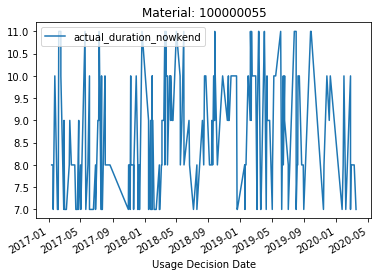

In [380]:
#Taking random group to test ARIMA model on
sub = mat_trend_trim[mats[0]]
sub.plot(x = 'Usage Decision Date', y = 'actual_duration_nowkend', title = "Material: %d" % mats[0])

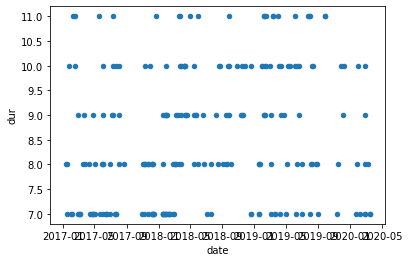

In [381]:
# Series of stamped time-series data
dates = sub['Usage Decision Date']
ts = pd.Series(sub['actual_duration_nowkend'].values, index=dates)

# Just visualizing data
dfmod = ts.to_frame()
dfmod.reset_index(inplace=True)
dfmod.columns = ['date','dur']
dfmod.plot(kind='scatter',x='date',y='dur')
plt.show()

In [382]:
# Array of external variables
exog_df = pd.DataFrame(sub['Total order quantity'])

# Convert to values for arima model
exog_arr = exog_df.values

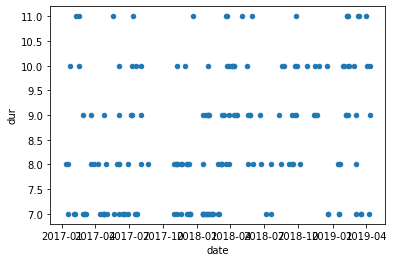

In [383]:
# Splitting data into test/train
ratio = 0.8
length = ts.shape[0]
pivot = int(ratio * length)
endpivot = length - pivot

ts_train = ts[:pivot]
ts_test = ts[pivot:]

exog_train = exog_arr[:pivot]
exog_test = exog_arr[pivot:]

dates_train = ts[:pivot]
dates_test = ts[pivot:]

# Just visualizing data
dfmod = ts_train.to_frame()
dfmod.reset_index(inplace=True)
dfmod.columns = ['date','dur']
dfmod.plot(kind = 'scatter', x='date',y='dur')
plt.show() 

In [384]:
# Fitting
arima = pm.auto_arima(ts_train, exog_train,start_p=1, start_q=1, max_p=3, max_q=3, m=12,start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings = True, stepwise=True)

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,12) [intercept=True]; AIC=586.054, BIC=604.616, Time=2.233 seconds
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=729.729, BIC=739.010, Time=0.131 seconds
Fit ARIMA(1,1,0)x(1,1,0,12) [intercept=True]; AIC=657.709, BIC=673.178, Time=0.623 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=591.193, BIC=606.662, Time=1.978 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.994)
Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=False]; AIC=727.729, BIC=733.916, Time=0.144 seconds
Fit ARIMA(1,1,1)x(0,1,0,12) [intercept=True]; AIC=659.862, BIC=675.331, Time=0.570 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA(1,1,1)x(1,1,1,12) [intercept=True]; AIC=587.861, BIC=609.517, Time=2.075 seconds
N

In [385]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -287.027
Date:                            Wed, 01 Jul 2020   AIC                            586.054
Time:                                    16:21:49   BIC                            604.616
Sample:                                         0   HQIC                           593.590
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.779      0.436      -0.001       0.003
x1            -0.0035      0.003     -1.283      0.200      -0.009       0.002
ar.L1          0.2367      0.088      2.699      0.007       0.065       0.409
ma.L1         -0.9993      1.461     -0.684      0.494      -3.862       1.864
ma.S.L12      -0.9995     18.052     -0.055      0.956     -36.380      34.381
sigma2         1.5533     27.667      0.056      0.955     -52.673      55.779
===================================================================================
Ljung-Box (Q):                       34.08   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.73   Prob(JB):                         0.66
Heteroskedasticity (H):               1.00   Skew:                             0.15
Prob(H) (two-sided):                  1.00   Kurtosis:                         2.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [386]:
arima.fit(ts_train, exog_train)

ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1, 12), suppress_warnings=True)

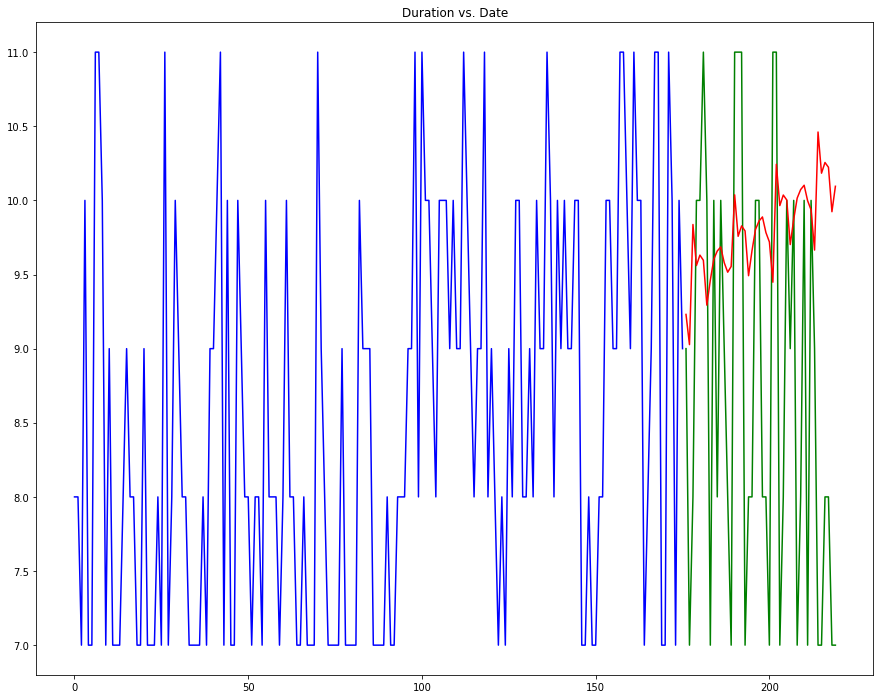

In [387]:
num_test = ts_test.shape[0]
# forecasts
forecasts = arima.predict(n_periods = num_test, exogenous = exog_test)  # predict 

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(length)
s = 2.0 ** 2
plt.plot(x[:pivot], ts_train, c='blue')
plt.plot(x[pivot:], ts_test, c = 'green')
plt.plot(x[pivot:], forecasts, c='red')
plt.gcf().set_size_inches(15, 12)
plt.title('Duration vs. Date')
plt.show()


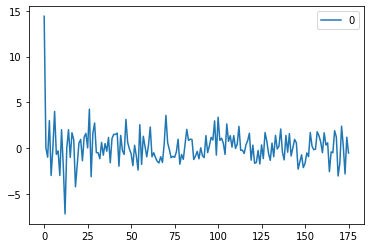

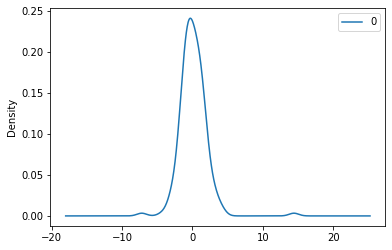

                0
count  176.000000
mean     0.095731
std      1.913710
min     -7.202805
25%     -0.954131
50%     -0.000969
75%      1.089289
max     14.401793


In [388]:
residuals = pd.DataFrame(arima.resid())
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [389]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(ts_test, forecasts)
print('Test MSE: %.3f' % error)

Test MSE: 3.385


## Second Try at ARIMA MODEL
Not completed

In [167]:
arima2 = pm.auto_arima(ts, exog_arr, m = 12, out_of_sample_size = endpivot, scoring = 'mse')

/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda3/envs/timeseries/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning

In [168]:
arima2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  343
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -826.663
Date:                Tue, 30 Jun 2020   AIC                           1665.325
Time:                        19:49:09   BIC                           1688.352
Sample:                             0   HQIC                          1674.498
                                - 343                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9979      0.677      1.474      0.141      -0.329       2.325
x1            -0.0063      0.001     -4.215      0.000      -0.009      -0.003
ar.L1          0.9520      0.031     30.701      0.000       0.891       1.013
ma.L1         -0.5322      0.047    -11.236      0.000      -0.625      -0.439
ma.L2         -0.1261      0.052     -2.430      0.015      -0.228      -0.024
sigma2         6.7784      0.425     15.949      0.000       5.945       7.611
===================================================================================
Ljung-Box (Q):                       25.84   Jarque-Bera (JB):               102.67
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.71
Prob(H) (two-sided):                  0.42   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""